# Imports

## Libraries

In [66]:
import geopandas as gpd
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

## Data

In [67]:
prov_gdf = gpd.read_file("../data/it_provinces_shapes.geojson", driver='geojson')
provinces_df = pd.read_csv("../data/provinces.csv", skipfooter=1)

In [68]:
prov_gdf.head(2)

,featurecla,scalerank,adm1_code,iso_3166_2,iso_a2,name,gns_region,geometry
0,Admin-1 scale rank,3,ITA-5442,IT-AO,IT,Aoste,IT19,"POLYGON ((7.02208 45.92526, 7.06694 45.89022, ..."
1,Admin-1 scale rank,3,ITA-5437,IT-VB,IT,Verbano-Cusio-Ossola,IT12,"POLYGON ((7.84962 45.93971, 7.87020 45.94037, ..."


In [69]:
provinces_df.head(2)

,Type,Province,Capital,Code,Region,Macroregion,Population (2019)[3],Area(km²),Density(p/km²),Comuni,President
0,F,Agrigento,Agrigento,AG,Sicily,Insular,"434,870","3,053",144,43,Marcello Maisano (commissioner)
1,O,Alessandria,Alessandria,AL,Piedmont,North-West,"421,284","3,559",119,188,Gianfranco Lorenzo Baldi (R)


<AxesSubplot:>

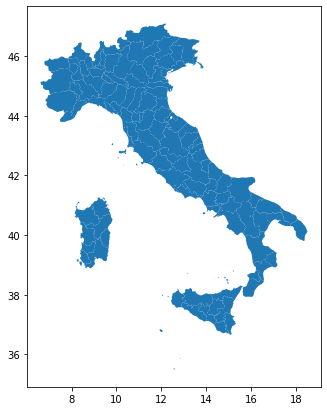

In [32]:
prov_gdf.plot(figsize=(7,7))

# Fixing dataframes

## Incorrect Value

In [9]:
naples_location = provinces_df[provinces_df['Capital'] == "Naples"].index[0]
provinces_df.Code[naples_location] = 'NA'

In [10]:
# Checking that all codes are 2 letters 
code_list = list(provinces_df.Code.unique())
for idx, x in enumerate(code_list):
    if type(x) != str:
        print(idx)
    if len(x) > 2:
        print(x)

## Feature Engineering

In [11]:
# preparing to combine prov_gdf and provinces_df
prov_gdf['Code'] = [x[-2:] for x in prov_gdf['iso_3166_2']]

## Datatype Correction

In [12]:
provinces_df['Population'] = provinces_df['Population (2019)[3]'].str.replace(',', '').astype(int)
provinces_df['Area'] = provinces_df['Area(km²)'].str.replace(',', '').astype(int)
provinces_df['Density'] = provinces_df['Density(p/km²)'].str.replace(',', '').astype(int)

## Dropping Unnecessary Columns

### From prov_gdf

In [13]:
unnecessary_cols = [x for x in prov_gdf.columns if (prov_gdf[x].nunique() == 1) ] # 1 value columns
unnecessary_cols.extend(['adm1_code', 'iso_3166_2', 'gns_region'])
prov_gdf.drop(columns= unnecessary_cols, inplace=True)

### From provinces_df

In [14]:
provinces_df.drop(columns = ['Type', 'Capital', 'Comuni', 'President'], inplace=True)

## Sardinian regions

Due to a consolidation of the provinces in 2014, Sardinia went from 8 provinces, to 4. The geodataframe still represents the pre-2014 structure. To correct for this, I will combine the provinces geometries when possible (in the case of "Olbia-Tempio" being consolidated into "Sassari"). Only for the current provinces of Cagliari and South Sardinia does this run into an issue since the geometries changed in 2014, too. Therefore, I will combine the pre-2014 provinces that make up these two provinces and treat both as a single "South_Sardinia" province. 

### Changing prov_gdf (geometries)

In [16]:
# viewing the sardinian regions
sard_geo = prov_gdf[64:72]
prov_gdf['Code'][64] = 'South_Sardinia'
prov_gdf['Code'][65] = 'Sass'
prov_gdf['Code'][67] = 'Sass'
prov_gdf['Code'][69] = 'South_Sardinia'
prov_gdf['Code'][70] = 'South_Sardinia'
prov_gdf['Code'][71] = 'South_Sardinia'

#### Merging Geometries

In [17]:
# merging the geometries of the new "regions"
prov_gdf2 = prov_gdf.dissolve(by='Code')

### Changing Provinces_df (populations)

In [18]:
south_sard_new_population = provinces_df['Population'][17] + provinces_df['Population'][83]

In [19]:
## new population for south_sardinia is 431038 + 350725 = 781763
provinces_df['Code'][17] = 'South_Sardinia'
provinces_df['Code'][83] = 'Sass'
provinces_df.drop(index = 87, inplace=True)
provinces_df['Population'][17] = south_sard_new_population

## Merging the 2 Dataframes

In [21]:
# checking the number of columns and rows
print(provinces_df.shape)
print(prov_gdf2.shape)

(106, 10)
(106, 2)


In [22]:
provinces_data_gdf = prov_gdf2.merge(provinces_df, on='Code', how='inner')
provinces_data_gdf.shape

(106, 12)

### Is the "name" column useful?

In [23]:
# the name column has the italian name or a past province name. All data looks correct
provinces_data_gdf[(provinces_data_gdf.name == provinces_data_gdf.Province) == False][0:3]

,Code,geometry,name,Province,Region,Macroregion,Population (2019)[3],Area(km²),Density(p/km²),Population,Area,Density
3,AO,"POLYGON ((7.02208 45.92526, 7.06694 45.89022, ...",Aoste,Aosta,Aosta Valley,North-West,"125,666","3,261",39,125666,3261,39
17,BT,"POLYGON ((15.97173 41.45390, 16.02166 41.42780...",Barletta-Andria Trani,Barletta-Andria-Trani,Apulia,South,"390,011","1,538",255,390011,1538,255
18,BZ,"POLYGON ((10.45183 46.54670, 10.45795 46.55370...",Bozen,South Tyrol,Trentino-South Tyrol,North-East,"531,178","7,400",69,531178,7400,69


## Removing Duplicate Columns

In [24]:
provinces_data_gdf.drop(columns = ['Population (2019)[3]', 'Area(km²)', 'Density(p/km²)'], inplace=True)

## More Feature Engineering

In [25]:
Cultural_regions_dict = {"Insular": "South", "South": "South", "Centre":"Center", "North-West":"North",
                        "North-East":"North"}

In [26]:
provinces_data_gdf['Country'] = 'Italy'
provinces_data_gdf['Cultural_region'] = provinces_data_gdf['Macroregion'].replace(Cultural_regions_dict)

In [27]:
province_geo_centroid = [provinces_data_gdf.geometry[x].centroid \
                                             for x in range(len(provinces_data_gdf))]

In [28]:
# weighting each region's latitude and longitude to its population
provinces_data_gdf['Pop_weighted_lat'] = [province_geo_centroid[x].coords[0][0] * 
                                          provinces_data_gdf['Population'][x]
                                         for x in range(len(provinces_data_gdf))]
provinces_data_gdf['Pop_weighted_lon'] = [province_geo_centroid[x].coords[0][1] * 
                                          provinces_data_gdf['Population'][x]
                                         for x in range(len(provinces_data_gdf))]

## Confirming that South Sardinia is in the correct geometry

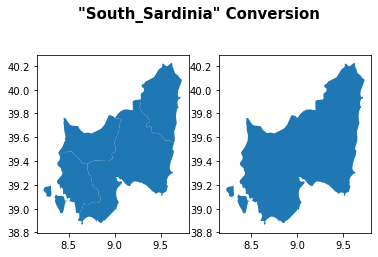

In [65]:
# plot on the same figure
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('"South_Sardinia" Conversion', fontweight="bold", fontsize=15)
prov_gdf[prov_gdf['Code'] == 'South_Sardinia'].plot(ax=ax1)
provinces_data_gdf[provinces_data_gdf['Code'] == 'South_Sardinia'].plot(ax=ax2)
plt.savefig("../images/South_Sardinia.png", bbox_inches='tight')

# Saving DataFrame

In [29]:
provinces_data_gdf.to_file("../data/provinces_gdf.geojson", driver='GeoJSON')